Found 4,741 total 'Production Output' files to analyze.

--- Part 1: Simulation for CURRENT Data ---

--- Target: 2.0 GB ---
  Initial Files: 4,741
  'Keepers' (already >2.0GB): 3,313
  New Merged Files: 425
  ==> TOTAL FINAL FILES: 3,738

--- Target: 4.0 GB ---
  Initial Files: 4,741
  'Keepers' (already >4.0GB): 729
  New Merged Files: 2,133
  ==> TOTAL FINAL FILES: 2,862

--- Target: 6.0 GB ---
  Initial Files: 4,741
  'Keepers' (already >6.0GB): 80
  New Merged Files: 1,879
  ==> TOTAL FINAL FILES: 1,959

--- Target: 8.0 GB ---
  Initial Files: 4,741
  'Keepers' (already >8.0GB): 80
  New Merged Files: 1,409
  ==> TOTAL FINAL FILES: 1,489

--- Target: 10.0 GB ---
  Initial Files: 4,741
  'Keepers' (already >10.0GB): 80
  New Merged Files: 1,127
  ==> TOTAL FINAL FILES: 1,207


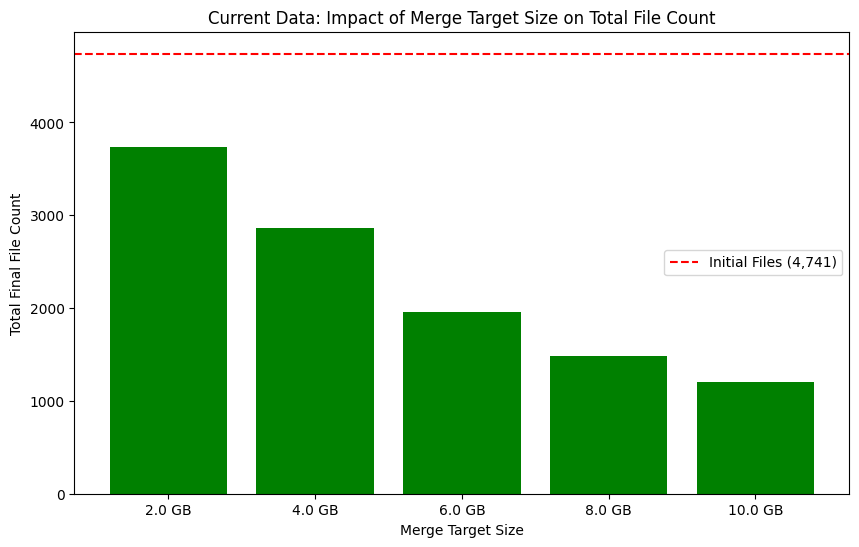



--- Part 2: Simulation for HL-LHC Scenario ---
Applying 5x size growth to each file.
Applying 10x count growth to total files.


--- Target: 2.0 GB ---
  Projected 'Keepers' (>2.0GB): 40,300
  Projected New Merged Files: 3,384
  ==> TOTAL PROJECTED FILES: 43,684

--- Target: 4.0 GB ---
  Projected 'Keepers' (>4.0GB): 36,860
  Projected New Merged Files: 4,164
  ==> TOTAL PROJECTED FILES: 41,024

--- Target: 8.0 GB ---
  Projected 'Keepers' (>8.0GB): 34,720
  Projected New Merged Files: 3,506
  ==> TOTAL PROJECTED FILES: 38,226

--- Target: 10.0 GB ---
  Projected 'Keepers' (>10.0GB): 33,130
  Projected New Merged Files: 4,248
  ==> TOTAL PROJECTED FILES: 37,378

--- Target: 16.0 GB ---
  Projected 'Keepers' (>16.0GB): 16,000
  Projected New Merged Files: 16,994
  ==> TOTAL PROJECTED FILES: 32,994

--- Target: 20.0 GB ---
  Projected 'Keepers' (>20.0GB): 7,290
  Projected New Merged Files: 21,329
  ==> TOTAL PROJECTED FILES: 28,619


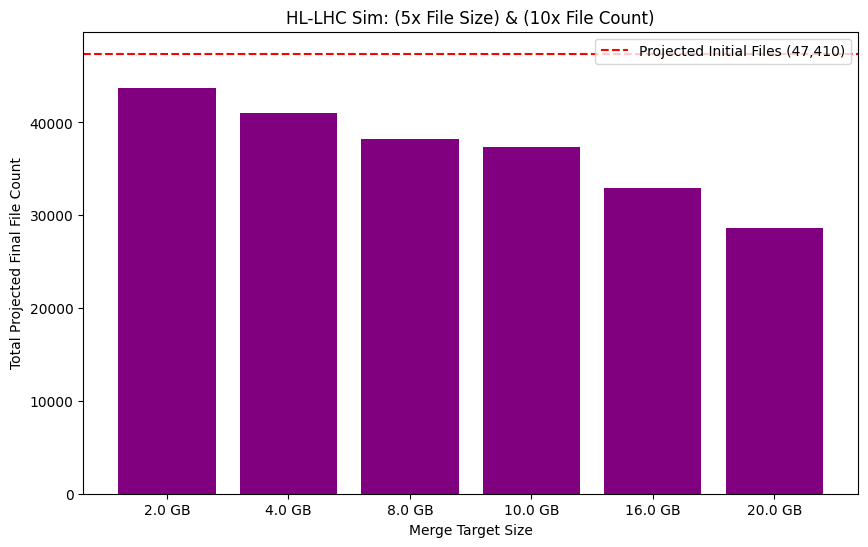

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Load and Filter Data
# -----------------------------
# Use the unmerged files only
try:
    data = pd.read_csv("/Users/khurtado/work/rd/fts_rucio_export_po_dc.csv")
except FileNotFoundError:
    print("Error: 'fts_rucio_export.csv' not found.")
    print("Please make sure the file is in the same directory as the script.")
    exit()

data['size_bytes'] = data['data.file_metadata.filesize'].fillna(data['data.user_filesize'])

production_activities = [
    "Production Output"
]

unmerged_files = data[
    (data['data.file_state'] == 'FINISHED') &
    (data['data.file_metadata.activity'].isin(production_activities))
].copy()

total_initial_files = len(unmerged_files)
if total_initial_files == 0:
    print("No 'Production Output' files found in the data. Exiting.")
    exit()
    
print(f"Found {total_initial_files:,} total 'Production Output' files to analyze.\n")

# ##############################################################################
# PART 1: SIMULATION FOR CURRENT DATA
# ##############################################################################

print("==============================================")
print("--- Part 1: Simulation for CURRENT Data ---")
print("==============================================")

# -----------------------------
# 2️⃣ Define Current Targets
# -----------------------------
current_targets_gb = [2.0, 4.0, 6.0, 8.0, 10.0]
current_final_counts = []

# ----------------------------------------------------
# 3️⃣ Simulate Merge Targets (Current Data, No Scaling)
# ----------------------------------------------------

for target_gb in current_targets_gb:
    target_bytes = target_gb * 1e9
    
    # --- A. Isolate the two groups based on CURRENT file size ---
    keepers = unmerged_files[unmerged_files['size_bytes'] >= target_bytes]
    num_keeper_files = len(keepers)
    
    mergeables = unmerged_files[unmerged_files['size_bytes'] < target_bytes]
    total_mergeable_volume_bytes = mergeables['size_bytes'].sum()
    
    # --- B. Calculate new merged files from the "Mergeable" group ---
    num_new_merged_files = np.ceil(total_mergeable_volume_bytes / target_bytes)
    
    # --- C. Calculate TOTAL final files ---
    total_final_files = num_keeper_files + num_new_merged_files
    current_final_counts.append(total_final_files)
    
    print(f"\n--- Target: {target_gb} GB ---")
    print(f"  Initial Files: {total_initial_files:,}")
    print(f"  'Keepers' (already >{target_gb}GB): {int(num_keeper_files):,}")
    print(f"  New Merged Files: {int(num_new_merged_files):,}")
    print(f"  ==> TOTAL FINAL FILES: {int(total_final_files):,}")

# -----------------------------
# 4️⃣ Plot Current Data Simulation
# -----------------------------
plt.figure(figsize=(10, 6))
plt.bar([str(t) + " GB" for t in current_targets_gb], current_final_counts, color='green')
plt.ylabel("Total Final File Count")
plt.xlabel("Merge Target Size")
plt.title("Current Data: Impact of Merge Target Size on Total File Count")
plt.axhline(y=total_initial_files, color='red', linestyle='--', label=f'Initial Files ({total_initial_files:,})')
plt.legend()
plt.show()


# ##############################################################################
# PART 2: SIMULATION FOR HL-LHC SCENARIO
# ##############################################################################

print("\n\n========================================================")
print("--- Part 2: Simulation for HL-LHC Scenario ---")
print("========================================================")

# -----------------------------
# 5️⃣ Define HL-LHC Factors and Targets
# -----------------------------
file_size_increase_factor = 5  # Each file is 5x larger 
file_count_increase_factor = 10 # 10x more files in total 

print(f"Applying {file_size_increase_factor}x size growth to each file.")
print(f"Applying {file_count_increase_factor}x count growth to total files.\n")

# Create a projected HL-LHC file size for each file
unmerged_files['hl_lhc_size_bytes'] = unmerged_files['size_bytes'] * file_size_increase_factor

# Define HL-LHC targets (centered around the new 10GB nominal)
hl_lhc_targets_gb = [2.0, 4.0, 8.0, 10.0, 16.0, 20.0]
hl_lhc_final_counts = []

# ----------------------------------------------------
# 6️⃣ Simulate Merge Targets (Using HL-LHC Projections)
# ----------------------------------------------------

for target_gb in hl_lhc_targets_gb:
    target_bytes = target_gb * 1e9
    
    # --- A. Isolate groups based on *HL-LHC SIZES* ---
    keepers = unmerged_files[unmerged_files['hl_lhc_size_bytes'] >= target_bytes]
    mergeables = unmerged_files[unmerged_files['hl_lhc_size_bytes'] < target_bytes]

    # --- B. Get CURRENT counts and volumes ---
    num_keepers_current = len(keepers)
    total_mergeable_volume_current = mergeables['hl_lhc_size_bytes'].sum()

    # --- C. Apply 10x File Count Scaling ---
    projected_keeper_files = num_keepers_current * file_count_increase_factor
    projected_mergeable_volume = total_mergeable_volume_current * file_count_increase_factor
    
    # --- D. Calculate new merged files from projected volume ---
    projected_new_merged_files = np.ceil(projected_mergeable_volume / target_bytes)
    
    # --- E. Calculate TOTAL projected files ---
    total_projected_files = projected_keeper_files + projected_new_merged_files
    hl_lhc_final_counts.append(total_projected_files)
    
    print(f"\n--- Target: {target_gb} GB ---")
    print(f"  Projected 'Keepers' (>{target_gb}GB): {int(projected_keeper_files):,}")
    print(f"  Projected New Merged Files: {int(projected_new_merged_files):,}")
    print(f"  ==> TOTAL PROJECTED FILES: {int(total_projected_files):,}")

# -----------------------------
# 7️⃣ Plot HL-LHC (5x Size, 10x Count) Simulation
# -----------------------------
projected_initial_files = total_initial_files * file_count_increase_factor

plt.figure(figsize=(10, 6))
plt.bar([str(t) + " GB" for t in hl_lhc_targets_gb], hl_lhc_final_counts, color='purple')
plt.ylabel("Total Projected Final File Count")
plt.xlabel("Merge Target Size")
plt.title(f"HL-LHC Sim: (5x File Size) & ({file_count_increase_factor}x File Count)")
plt.axhline(y=projected_initial_files, color='red', linestyle='--', label=f'Projected Initial Files ({projected_initial_files:,})')
plt.legend()
plt.show()